La idea de este proyecto es usarlo como ejemplo, para implementarlo en el proyecto de Bitcoin y hacer una comparativa entre ambas predicciones LGBM vs LSTM. 

In [1]:
import tensorflow as tf
import os
import pandas as pd 
import numpy as np 
import seaborn as sns

2023-07-17 18:45:14.779104: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-17 18:45:14.968676: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-17 18:45:14.968715: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-17 18:45:15.025612: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-17 18:45:16.529132: W tensorflow/stream_executor/pla

Extraemos data de temperatura, presión, etc...  

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip', 
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13568290/13568290 [==============================] - 0s 0us/step


el dataframe se ve de la siguiente forma, 

In [3]:
df = pd.read_csv(csv_path)
df.head()  

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


La cantidad de info en muchísima, consideramos la data cada una hora. 

In [4]:
df = df[5::6] 
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.20,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.50,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.60,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.20,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420521,31.12.2016 19:10:00,1002.18,-0.98,272.01,-5.36,72.00,5.69,4.09,1.59,2.54,4.08,1280.70,0.87,1.36,190.6
420527,31.12.2016 20:10:00,1001.40,-1.40,271.66,-6.84,66.29,5.51,3.65,1.86,2.27,3.65,1281.87,1.02,1.92,225.4
420533,31.12.2016 21:10:00,1001.19,-2.75,270.32,-6.90,72.90,4.99,3.64,1.35,2.26,3.63,1288.02,0.71,1.56,158.7
420539,31.12.2016 22:10:00,1000.65,-2.89,270.22,-7.15,72.30,4.93,3.57,1.37,2.22,3.57,1288.03,0.35,0.68,216.7


Nos concentramos en la temperatura, creamos un nuevo dataframe llamado temp. 

<AxesSubplot: xlabel='Date Time', ylabel='T (degC)'>

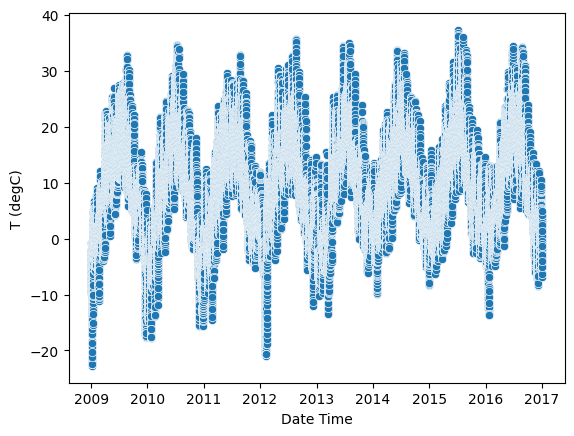

In [5]:
df.index = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
temp = df['T (degC)']
sns.scatterplot(data=temp)

Vemos que los datos tienen cierta regularidad. Debería ser posible hacer una predicción. Preparando la data para el forecast, tenemos que lograr esto en nuestra serie de tiempo: 

In [6]:
# [[[1],[2],[3],[4],[5]]]   [6] 
# [[[2],[3],[4],[5],[6]]]   [7]
# [[[3],[4],[5],[6],[7]]]   [8]
#         X                  y

"X" tiene la forma de 'lista de listas', donde para cada línea, la serie de tiempo aumenta en una unidad. Lo mismo ocurre para la columna "y". Creamos una función que transforma el dataframe de temp en "X" e "y".   

In [7]:
def df_to_X_y(df, window_size=5): #El ws corresponde a el largo del row, podría no ser siempre igual. 
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+5]]
        X.append(row) # Agregamos la lista en X
        label = df_as_np[i+5]
        y.append(label) # Agregamos el elemento que corresponde en y
    return np.array(X), np.array(y)

In [8]:
WINDOW_SIZE = 5
X, y = df_to_X_y(temp, WINDOW_SIZE)
X.shape, y.shape

((70086, 5, 1), (70086,))

El shape de X es (N° de filas, N° de col, elementos). Si vemos el dataframe temp, no concuerda la cantidad de datos (70091) con el shape de X (70086). Esto es, porque los últimos 5 terminos de temp no alcanzan a 'iterar' en la función. Ahora definimos los valores de entrenamiento:      

In [9]:
X_train, y_train = X[:60000], y[:60000] 
X_val, y_val = X[60000:65000], y[60000:65000]
X_test, y_test = X[65000:], y[65000:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape  

((60000, 5, 1), (60000,), (5000, 5, 1), (5000,), (5086, 5, 1), (5086,))

Acá, entrenaremos con los primeros 60000 términos. La segunda línea es de validación 60000-65000, estos datos son ocupados por el algoritmo para ajustar sus propios parámetros en cada 'epoch' y dismimuir el error. La tercera línea es de testeo, la usaremos para ver como predice nuestro forecast respecto a datos reales. Importamos los paquetes necesarios, llamamos a nuestro modelo 'model1' y tendrá los parámetros para realizar el forecast.              

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1= Sequential() #Keras es una API secuencial 
model1.add(InputLayer((5, 1))) #Especificamos el 'shape' de X
model1.add(LSTM(64)) # Especificamos la dimensionalidad del espacio de salida
model1.add(Dense(8, 'relu'))     
model1.add(Dense(1, 'linear'))

model1.summary()

2023-07-17 18:45:25.414598: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-07-17 18:45:25.414633: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-07-17 18:45:25.414652: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-2bea62e9-8d22-46a6-9eb4-51194a5da2d7): /proc/driver/nvidia/version does not exist
2023-07-17 18:45:25.414888: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Model: "sequential"
________________________________________________________

Acá las instrucciones Dense(UNITS,ACTIVATION) (fully-connected layer) indica que las neuronas de la iteración x están conectadas con todas las neuronas de la iteración x+1. UNITS:It is the most primitive of all the parameters. It accepts only a positive integer and defines the size of the output vector from the dense layer,i.e., determines the size of the weight matrix along with the bias vector. ACTIVATION: It helps define the activation function that can be applied per element of a dense layer. There are various types of activation functions provided by Keras, such as relu, sigmoid, softmax, Selu, Elu, Tanh, and many more. If not specified, it uses a linear activation function. Finalmente lo importante es que comenzamos con una red neuronal de muchos parámetros, la función Dense (8) y Dense (1) solo nos entrega uno, como resultado de la predicción.   Ahora creamos un CheckPoint y generamos el compilador,  

In [11]:
cp = ModelCheckpoint('model1/', save_best_only=True) #Solo guarda la iteración que tenga el menor 'validation loss' 
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

El optimizer es crucial para determinar la precisión de la predicción, acá dejo una descripción de cada posibilidad: https://deepdatascience.wordpress.com/2016/11/18/which-lstm-optimizer-to-use/ , el learning_rate es un valor que si lo aumentamos, el modelo logrará reducir más rapidamente el 'validation loss', pero no siempre un valor alto es más óptimo, depende del dataset. Ahora entrenamos el modelo y generamos la predicción. La predicción quedará guardada en la carpeta 'model1'.  

In [12]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=10, callbacks=[cp])

Epoch 1/10
1865/1875 [============================>.] - ETA: 0s - loss: 33.8538 - root_mean_squared_error: 5.8184WARNING:absl:Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses while saving (showing 2 of 2). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: model1/assets
INFO:tensorflow:Assets written to: model1/assets
1875/1875 [==============================] - 20s 10ms/step - loss: 33.7031 - root_mean_squared_error: 5.8054 - val_loss: 1.2735 - val_root_mean_squared_error: 1.1285
Epoch 2/10
1871/1875 [============================>.] - ETA: 0s - loss: 2.3237 - root_mean_squared_error: 1.5244WARNING:absl:Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses while saving (showing 2 of 2). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: model1/assets
INFO:tensorflow:Assets written to:

Importamos la data guardada. 

In [13]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/') 

Creamos un dataset con una columna de predicción y otra columna con los datos reales.

In [15]:
train_predictions = model1.predict(X_train).flatten() #EL shape del X_train es array[[],[]...] por eso aplicamos flatten  
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
train_results 

1875/1875 [==============================] - 6s 3ms/step


,Train Predictions,Actuals
0,-9.759680,-9.67
1,-9.597444,-9.17
2,-8.792332,-8.10
3,-7.452445,-7.66
4,-7.290732,-7.04
...,...,...
59995,6.034591,6.07
59996,7.268508,9.88
59997,12.343010,13.53
59998,16.103727,15.43


Graficamos juntos, los 500 primeros datos reales y datos predichos.  

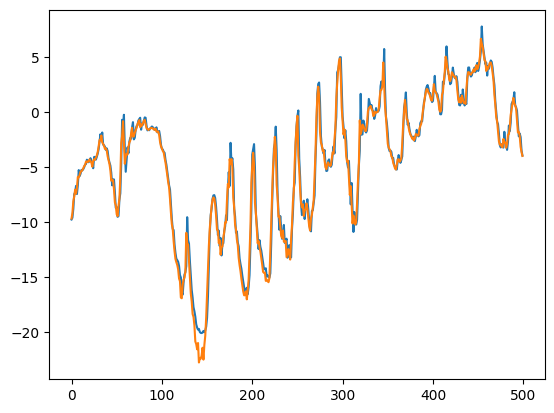

In [16]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][:500])
plt.plot(train_results['Actuals'][:500])

Vemos como están los datos de validación que utilizó la red neuronal para disminuir el 'validation loss'.  

In [17]:
val_predictions = model1.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val})
val_results 

157/157 [==============================] - 1s 4ms/step


,Val Predictions,Actuals
0,15.532570,14.02
1,13.255650,13.67
2,13.056093,12.27
3,11.545275,11.19
4,10.424231,10.85
...,...,...
4995,17.292095,18.27
4996,17.362385,17.85
4997,17.172123,16.65
4998,15.875072,15.85


Vemos como se comportan, los datos reales con los de validación.  

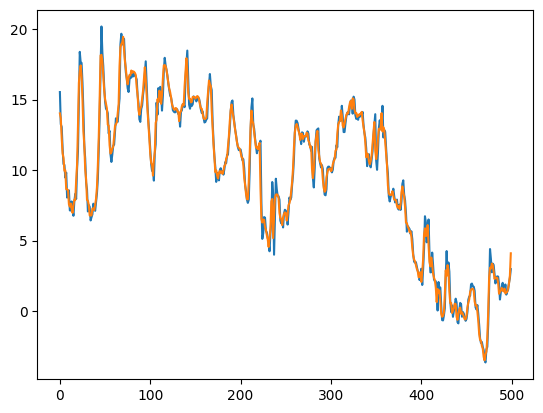

In [18]:
plt.plot(val_results['Val Predictions'][:500])
plt.plot(val_results['Actuals'][:500])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2bea62e9-8d22-46a6-9eb4-51194a5da2d7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>